In [2]:
import sys
from optparse import OptionParser
import pickle

from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

plt.rcParams['xtick.labelsize']= 12
plt.rcParams['ytick.labelsize']= 12
plt.rcParams['font.size']= 12

import pickle
import os
import json

from plotbin.plot_velfield import plot_velfield
from jampy.mge_radial_density import mge_radial_density
from jampy.mge_radial_mass import mge_radial_mass
from jampy.mge_half_light_isophote import mge_half_light_isophote
from astropy import units as u

import autolens as al
import autolens.plot as aplt

from util import quantities2D, quantities3D
from dyLens.utils.tools import effective_einstein_radius_from_kappa, enclosed2D
from dyLens.Combined import updt_model
from copy import deepcopy

In [286]:
phase_name    = "phase5"   # phase to compute the results
result_path   = "./8/model1/"  #path to the non-linear results
data_path     = "/home/carlosmelo/Documents/GitHub/Illustris/my_illustris/TNG50-1-snap84-subhalo8 (original)/" #path to the data

In [4]:
with open(result_path+'{}/Final_sampler_{}.pickle'.format(phase_name,phase_name),'rb') as f:
    sampler = pickle.load(f)
    f.close()
    try:
        sampler = sampler["sampler"]
    except:
        sampler = sampler
    
with open(result_path+'/JAM/Final_sampler.pickle','rb') as f:
    sampler_JAM = pickle.load(f)
    f.close()
    try:
        sampler_JAM = sampler_JAM["sampler"]
    except:
        sampler_JAM = sampler_JAM

with open(result_path+'{}/{}.pickle'.format(phase_name,phase_name),'rb') as f:
    phase = pickle.load(f)
    f.close()
    
with open(result_path+f'/JAM/JAM_class.pickle','rb') as f:
    Jam_Model = pickle.load(f)
    f.close()

with open(result_path+'{}/CombinedModel_{}.pickle'.format(phase_name,phase_name),'rb') as f:
    CM = pickle.load(f)
    f.close()
    
with open(result_path+'{}/priors_{}.pickle'.format(phase_name,phase_name),'rb') as f:
    priors = pickle.load(f)
    f.close()
    
with open(result_path+'/JAM/priors.pickle','rb') as f:
    priors_JAM = pickle.load(f)
    f.close()

In [5]:
fancy_labels = {
            "ml"   :    r"$\Upsilon$",
            "ml0"  :    r"$\Upsilon_{0}$",
            "delta":    r"$\delta$",
            "lower":    r"$\upsilon$",
            "beta" :    r"$\beta_{z}$",
            "inc"  :    r"$i$",
            "log_mbh":  r"$\log_{10}M_{\text{bh}}$",
            "log_rho_s":r"$\log_{10}\rho_{s}$",
            "log_M0":   r"$\log_{10}M_{0}$",
            "rc"    :   r"$r_{c}$",
            "rs"    :   r"$r_{s}$",
            "qDM"   :   r"$q_{\text{DM}}$",
            "slope" :   r"$\gamma$",
            "mag_shear":r"$\Gamma$",
            "phi_shear":r"$\Gamma_{\theta}$",
            "gamma":    r"$\eta$"    
}

In [6]:
# Generate a new set of results with statistical+sampling uncertainties.
sampler.results.summary()
parsRes = priors.copy()
results_sim = dyfunc.jitter_run(dyfunc.resample_run(sampler.results))
samples_sim, weights = results_sim.samples, results_sim.importance_weights()
samples_equal = results_sim.samples_equal()
quantiles = [dyfunc.quantile(samps, [0.16, 0.5,  0.84], weights=weights)
            for samps in samples_sim.T]                        #quantiles for each parameter

labels = []
for i, key in enumerate(parsRes.keys()):
    parsRes[key] = quantiles[i][1]
    labels.append( fancy_labels[key] )
    

Summary
nlive: 500
niter: 3864
ncall: 50100
eff(%):  8.711
logz: 5430.706 +/-  0.134


In [320]:
samples_equal[0]

array([ 8.08172148e+01, -2.88888270e-02,  1.99272795e+00, -1.94386299e+00,
        9.67013940e+00,  8.93860095e-01])

In [321]:
samples_sim[0]

array([ 8.48632775e+01, -1.34551737e-02,  2.38863612e+00, -1.89022252e+00,
        1.57790862e+01,  9.12140669e-01])

In [314]:
quantiles = [dyfunc.quantile(samps, [0.16, 0.5,  0.84],)
            for samps in samples_equal.T]    


for i in range(sampler.npdim):
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(quantiles[i][1], quantiles[i][0], quantiles[i][2], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [309]:
from IPython.display import display, Math

for i in range(sampler.npdim):
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(quantiles[i][1], quantiles[i][0], quantiles[i][2], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

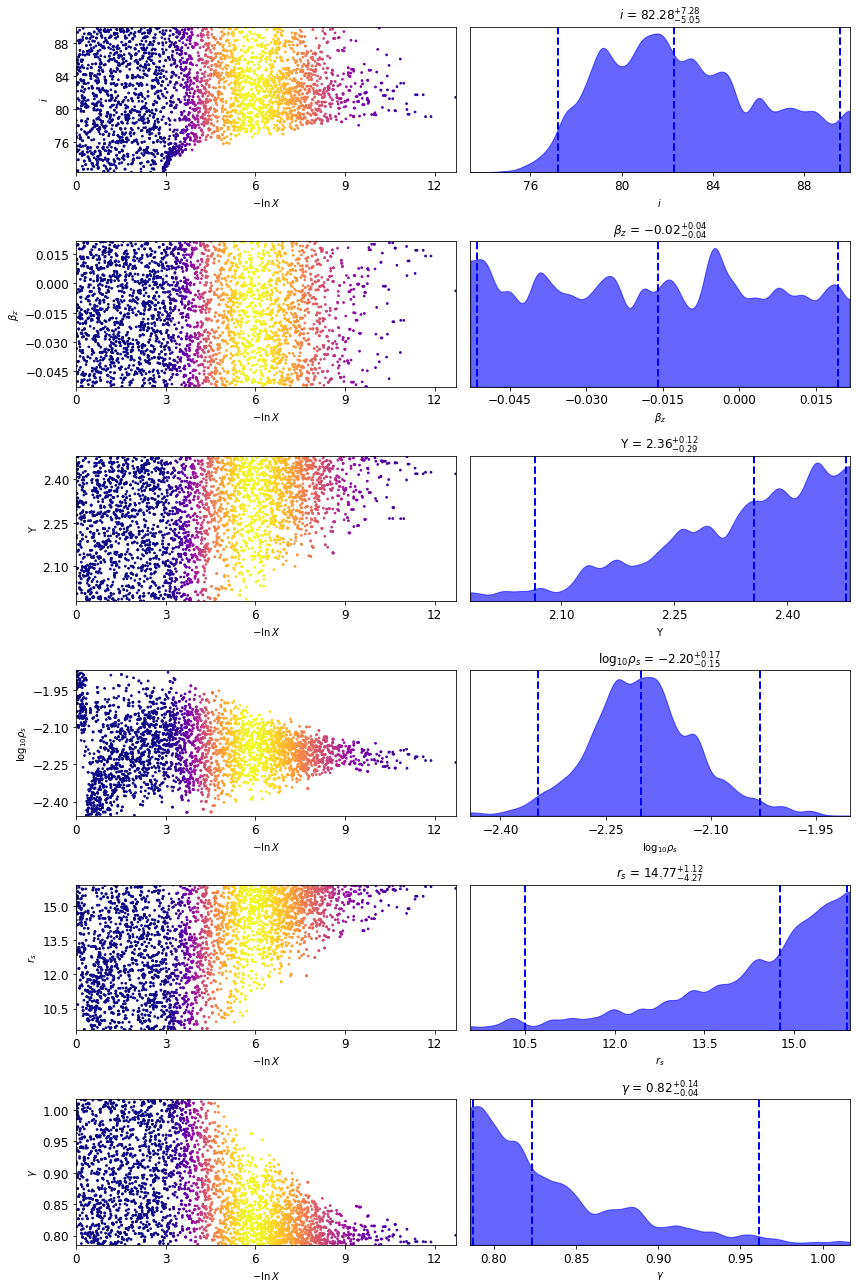

In [7]:
fig, axes = dyplot.traceplot(results=results_sim, show_titles=True,
                             labels=labels,
                             )
fig.tight_layout()

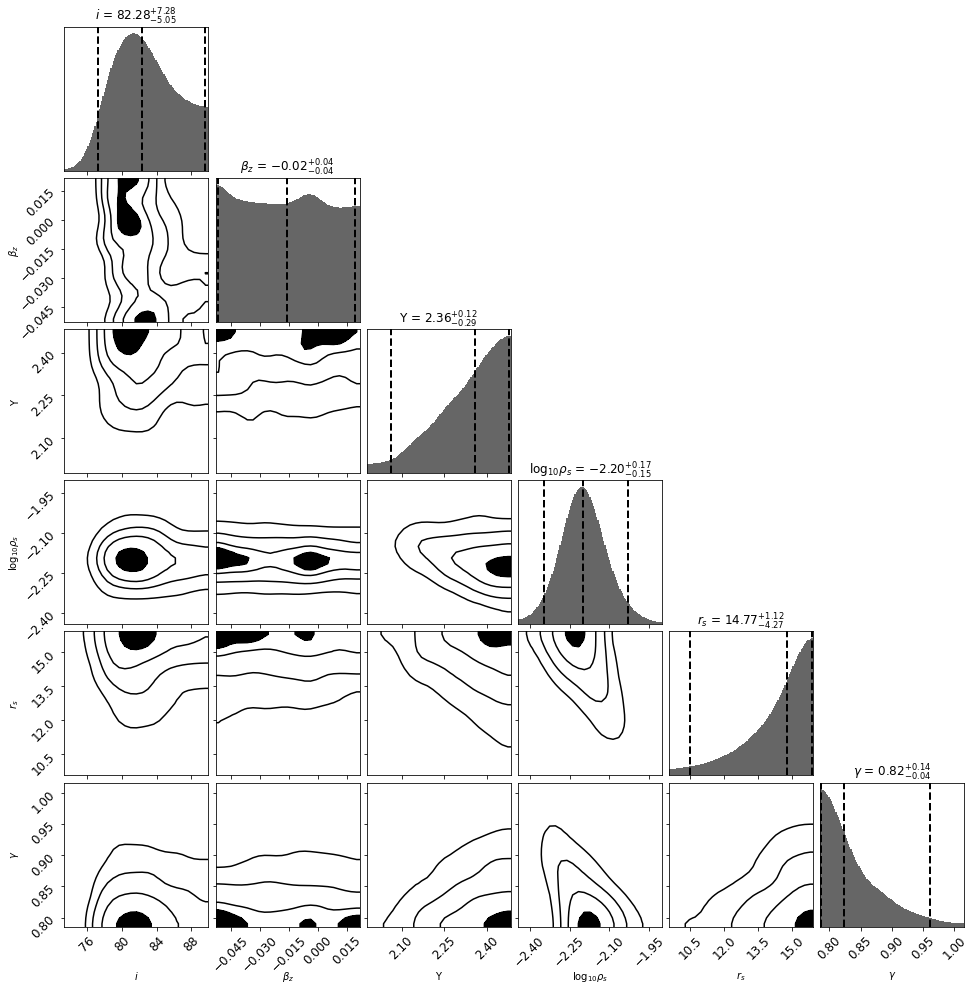

In [8]:
cfig, caxes, = dyplot.cornerplot(results_sim, smooth=0.08,
                                    show_titles=True,labels=labels,
                            )
fig.tight_layout()

In [9]:
phase.CombinedModel

In [10]:
if phase_name == "phase1":
    source_ell_comp = al.convert.elliptical_comps_from(axis_ratio=parsRes["source_q"], 
                                                       angle=parsRes["source_phi"])

    source_model = al.Galaxy(
        redshift=phase.CombinedModel.Lens_model.z_s,
        light=al.lp.EllSersic(
            centre=(parsRes["source_y0"], parsRes["source_x0"]),
            elliptical_comps=source_ell_comp,
            intensity=parsRes["source_intensity"],
            effective_radius=parsRes["source_eff_r"],
            sersic_index=parsRes["source_n_index"],
        ),
    )    


    phase.CombinedModel.source_galaxy(source_model)

else:
    
    adp_pix = phase.source_pix(pixels=int(phase.parsSource["pixels"]),
                                weight_floor=phase.parsSource["weight_floor"],
                                weight_power=phase.parsSource["weight_power"]
                                )

    adp_reg = phase.source_reg(inner_coefficient=phase.parsSource["inner_coefficient"],
                                outer_coefficient=phase.parsSource["outer_coefficient"],
                                signal_scale=phase.parsSource["signal_scale"]
                                )

    source_model = al.Galaxy(redshift=phase.CombinedModel.Lens_model.z_s,
                                pixelization=adp_pix, regularization=adp_reg,
                                hyper_model_image=phase.hyper_image_2d,
                                hyper_galaxy_image=phase.hyper_image_2d,
                                )

    phase.CombinedModel.source_galaxy(source_model=source_model)  #Setting the source galaxy model
phase.CombinedModel.quiet = False
phase.CombinedModel.Updt_Model(parsRes)



 --------------------------------- 

ParsDic: {'inc': 82.28497161743742, 'beta': -0.015863364077481706, 'ml': 2.3555985020541215, 'log_rho_s': -2.200405558329219, 'rs': 14.767647663851024, 'qDM': 1.0, 'slope': 0.8233717223301977, 'gamma': 1.0}

 --------------------------------- 

Parameters Updated!


Generating lensing results. This could take a while.


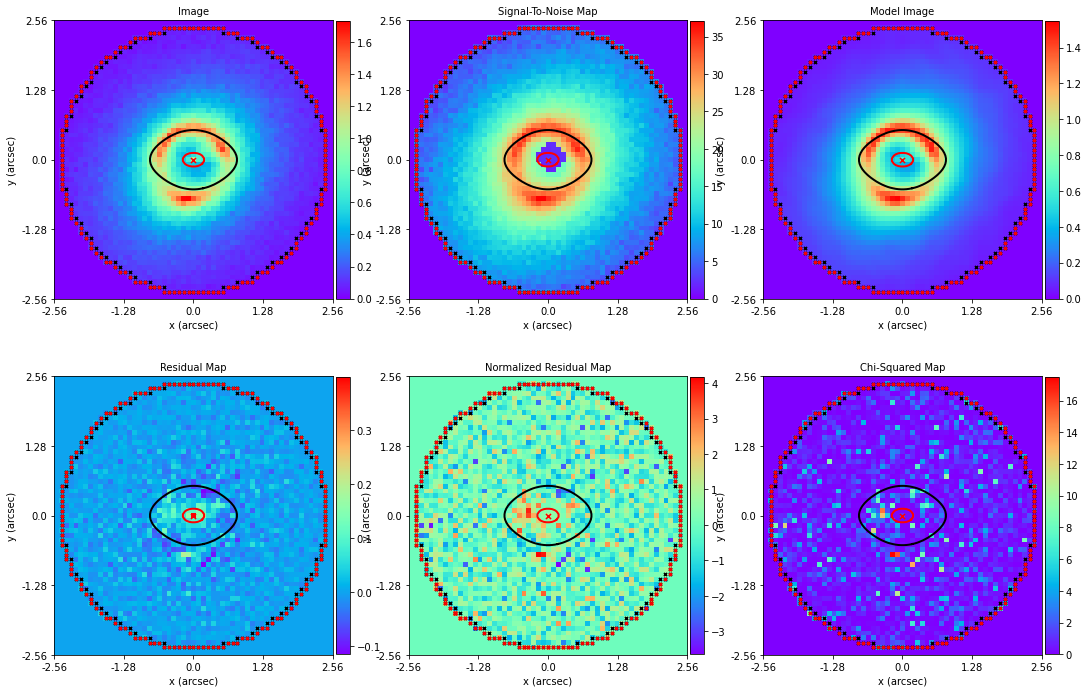

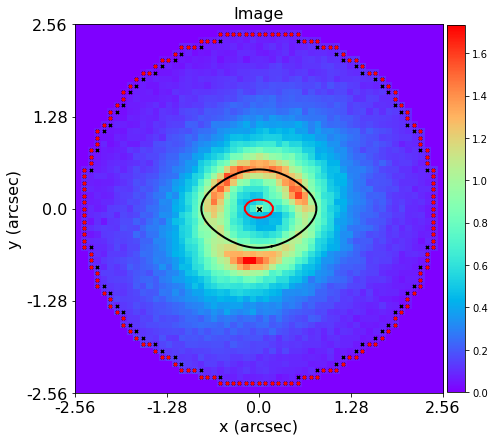

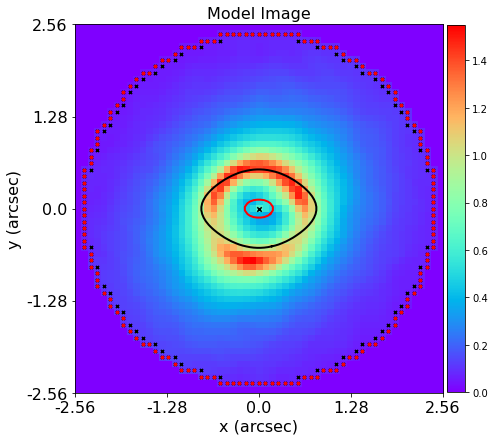

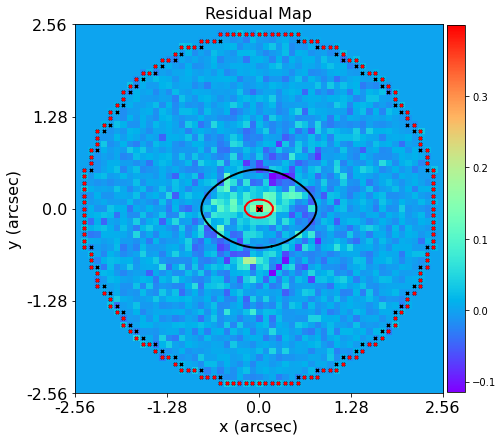

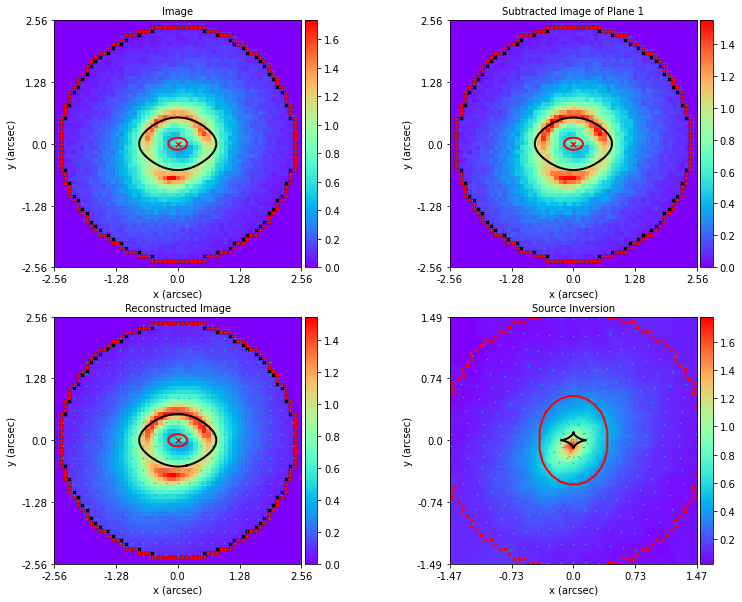

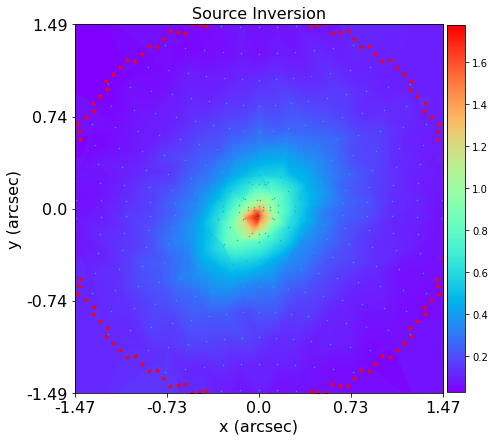

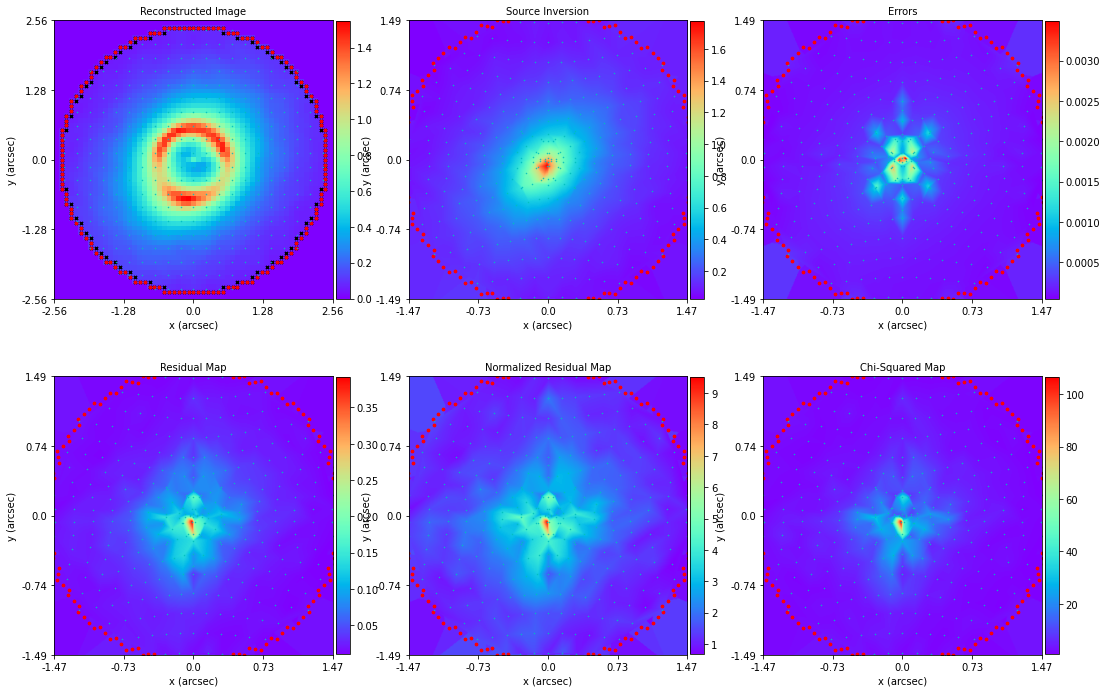

In [11]:
print("Generating lensing results. This could take a while.")

# Config. Pyautolens plots
cmap = aplt.Cmap(cmap="rainbow")

mat_plot_2d_output = aplt.MatPlot2D(cmap=cmap)
mat_plot_2d =  mat_plot_2d_output
# Make a fit plotter
fit_plotter = aplt.FitImagingPlotter(fit=phase.CombinedModel.Fit, mat_plot_2d=mat_plot_2d)

mat_plot_2d.output.filename = "fit_subplot"
fit_plotter.subplot_fit_imaging()

mat_plot_2d.output.filename = "fit_image"
fit_plotter.figures_2d(image=True)

mat_plot_2d.output.filename = "fit_model"
fit_plotter.figures_2d(model_image=True)

mat_plot_2d.output.filename = "residual"
fit_plotter.figures_2d(residual_map=True)

mat_plot_2d.output.filename = "subplot_plane"
fit_plotter.subplot_of_planes(plane_index=1)

# Make a inversion plotter
inversion_plotter = aplt.InversionPlotter(inversion=phase.CombinedModel.Fit.inversion, 
                                    mat_plot_2d=mat_plot_2d)

mat_plot_2d.output.filename = "reconstruction"
inversion_plotter.figures_2d_of_mapper(mapper_index=0,
                reconstruction=True)

mat_plot_2d.output.filename = "subplot_inversion"
inversion_plotter.subplot_of_mapper(mapper_index=0)

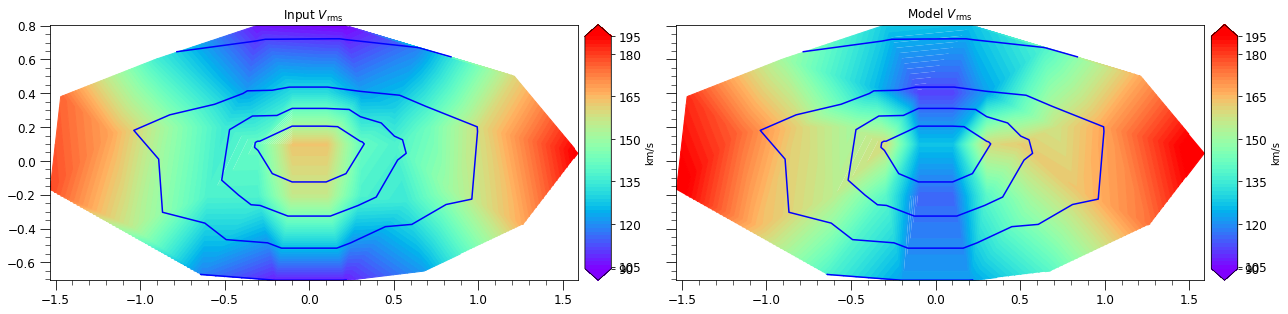

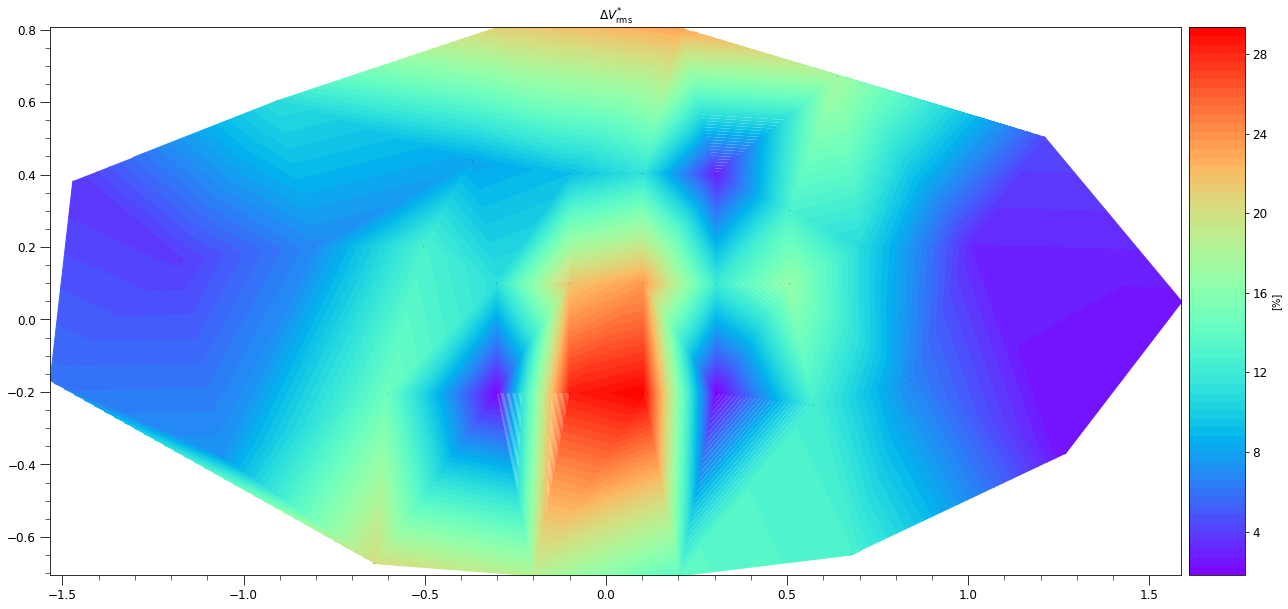

In [12]:
fig = plt.figure(figsize=(18, 10))
rmsModel, ml, chi2, chi2T = phase.CombinedModel.Jampy_model._run(plot=True, cmap="rainbow", label=r"km/s", xlabel="arcsec")

plt.tight_layout()

fig = plt.figure(figsize=(18, 10))
plot_velfield(phase.CombinedModel.Jampy_model.xbin, phase.CombinedModel.Jampy_model.ybin, 
            100*abs(phase.CombinedModel.Jampy_model.rms-rmsModel)/phase.CombinedModel.Jampy_model.rms,
            colorbar=True,  cmap="rainbow",  
            markersize=0.2, label="[%]")
plt.title(r"${\Delta V_{\rm rms}^{*}}$")

fig.tight_layout()

In [13]:
## stellar mass
    
    # one surf lum for each ml in the sample
surf_lum  = np.asarray ( samples_sim.shape[0] * [phase.CombinedModel.Lens_model.surf_lum] )
sigma_lum = np.asarray ( samples_sim.shape[0] * [phase.CombinedModel.Lens_model.sigma_lum] )
qobs_lum  = np.asarray ( samples_sim.shape[0] * [phase.CombinedModel.Lens_model.qobs_lum] )


idx_ml  = list(priors.keys()).index("ml") # ml index
    # ml sample. One ML per gaussian in surf lum
ml_dist = np.asarray ( surf_lum.shape[1] * [samples_sim[:,idx_ml]] ).T
# one surf stellar mass MGE for each ml in the sample
surf_stellar_mass_dist = ml_dist * surf_lum

idx_inc  = list(priors.keys()).index("inc") # inc index
inc_dist = np.asarray ( surf_lum.shape[1] * [samples_sim[:,idx_inc]] ).T 

R = np.asarray( [1.3618855704163972] * samples_sim.shape[0] )
    
stellar_mass_dist = mge_radial_mass(surf_stellar_mass_dist, 
                sigma_lum, qobs_lum,
                inc_dist, R, phase.CombinedModel.Jampy_model.distance)    


In [14]:
median_stellar_mass = dyfunc.quantile(stellar_mass_dist, 0.5, weights=weights)
lo_stellar_mass = dyfunc.quantile(stellar_mass_dist, 0.16, weights=weights)
hi_stellar_mass = dyfunc.quantile(stellar_mass_dist, 0.84, weights=weights)

In [15]:
fidual_stellar_mass = mge_radial_mass(phase.CombinedModel.Jampy_model.surf_lum * phase.CombinedModel.Jampy_model.ml_model, 
                phase.CombinedModel.Jampy_model.sigma_lum, phase.CombinedModel.Jampy_model.qobs_lum,
                phase.CombinedModel.Jampy_model.inc, 1.3618855704163972, phase.CombinedModel.Jampy_model.distance)

In [16]:
np.log10(fidual_stellar_mass), np.log10(median_stellar_mass)

(array([10.4466773]), array([10.50335491]))

In [17]:
np.log10(fidual_stellar_mass), np.log10(median_stellar_mass), np.log10(lo_stellar_mass), np.log10(hi_stellar_mass)

(array([10.4466773]),
 array([10.50335491]),
 array([10.4763792]),
 array([10.51966838]))

In [18]:
(10.514312794352605 - 10.4466773)/10.514312794352605

0.006432707079908647

In [19]:
(10.514312794352605 - 10.50408735)/10.514312794352605

0.0009725261700504934

In [196]:
idx_rho_s  = list(priors.keys()).index("log_rho_s") # ml index
rho_s = 10 **  samples_sim[:,idx_rho_s]

idx_r_s  = list(priors.keys()).index("rs") # ml index
r_s      = samples_sim[:,idx_r_s]

idx_slope = list(priors.keys()).index("slope") # ml index
slope     =  samples_sim[:,idx_slope]


In [267]:
c = np.asarray( [[rho_s[0], r_s[0], slope[0]], 
                 [rho_s[1], r_s[1], slope[1]],
               [rho_s[1], r_s[1], slope[1]],
                [rho_s[1], r_s[1], slope[1]]]
              )
c[0]

c.shape

(4, 3)

In [247]:
su, sig = phase.CombinedModel.mgeDM.fit(*c[1])

In [248]:
from multiprocessing import Pool
from functools import partial
surf = []
sigma = []


In [270]:
pars = np.vstack([rho_s, r_s, slope]).T

In [271]:
with Pool(4) as p:
    surf, sigma = zip(*p.starmap(phase.CombinedModel.mgeDM.fit, pars))
    p.close()
    p.join()

In [273]:
a = np.asarray(surf)
b = np.asarray(sigma)
c = np.full_like(b , 1)
d = np.asarray ( a.shape[1] * [samples_sim[:,idx_inc]] ).T 

In [274]:
R = np.asarray( [1.3618855704163972] * samples_sim.shape[0] )
    
dm_mass_dist = mge_radial_mass(a, 
                b, c,
                d, R, phase.CombinedModel.Jampy_model.distance)

In [275]:
median_dm_mass = dyfunc.quantile(dm_mass_dist, 0.5, weights=weights)
lo_dm_mass = dyfunc.quantile(dm_mass_dist, 0.16, weights=weights)
hi_dm_mass = dyfunc.quantile(dm_mass_dist, 0.84, weights=weights)

In [276]:
np.log10(median_dm_mass),

(array([10.34122185]),)

In [277]:
np.log10(lo_dm_mass), np.log10(hi_dm_mass)

(array([10.31188197]), array([10.38356248]))

In [278]:
total_mass_dist = (stellar_mass_dist + dm_mass_dist)
fdm_dist = dm_mass_dist/total_mass_dist

In [279]:
median_total_mass = dyfunc.quantile(total_mass_dist, 0.5, weights=weights)
np.log10(median_total_mass)

array([10.73006574])

In [280]:
median_fdm = dyfunc.quantile(fdm_dist, 0.5, weights=weights)
median_fdm

[0.40768959802528904]

In [281]:
radii    = np.arange(0.25, 10, 0.01) # Radii in arcsec

pc       = Jam_Model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc                        # Radii in pc

dm_radial_density = []

for w in range(a.shape[0]):
    dm_radial_density.append( mge_radial_density(a[w], 
                                b[w], c[w],
                                inc_dist[w][0], radii, Jam_Model.distance) )


In [282]:
fiducial_surf, fiducial_sigma = phase.CombinedModel.mgeDM.fit(10**parsRes["log_rho_s"], 
                                                              parsRes["rs"],
                                                              parsRes["slope"])
fiducial_qobs = np.ones_like(fiducial_surf)

In [283]:
fiducial_density = mge_radial_density(fiducial_surf, 
                                fiducial_sigma, fiducial_qobs,
                                parsRes["inc"], radii, Jam_Model.distance)

In [284]:
from scipy.stats.mstats import mquantiles


# median and 1sigma band
mean = mquantiles(dm_radial_density, 0.5, axis=0)[0]
lo   = mquantiles(dm_radial_density, 0.025, axis=0)[0]
hi   = mquantiles(dm_radial_density, 0.975, axis=0)[0]

In [287]:
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
true_density = dm_hdu[1].data["density"]
true_radii   = dm_hdu[1].data["radius"]
dm_fit       = dm_hdu[1].data["bestfit"]

i = true_radii < radii_pc.max()

true_density = true_density[i]
true_radii   = true_radii[i]
dm_fit = dm_fit[i]

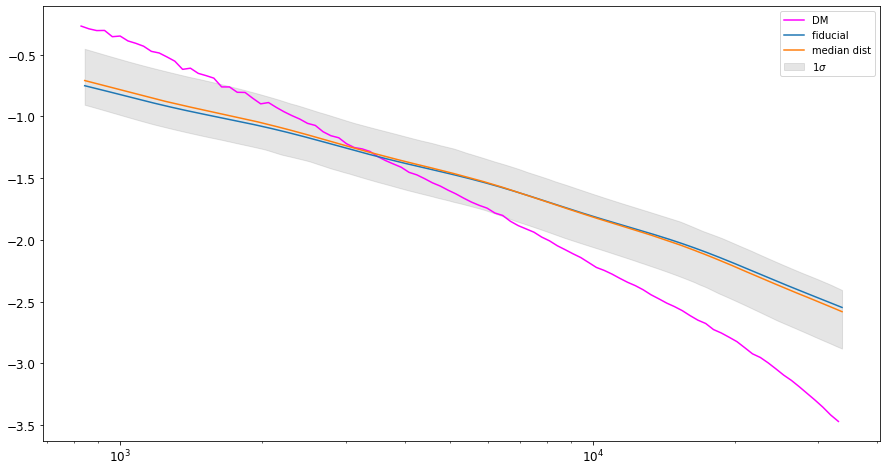

In [288]:
plt.figure(figsize=(15,8))

plt.plot(true_radii, np.log10(true_density), label="DM", color="magenta")
plt.plot(radii_pc, np.log10(fiducial_density), label="fiducial ")
plt.plot(radii_pc, np.log10(mean), label="median dist")
plt.fill_between(radii_pc, np.log10(lo), np.log10(hi), color="gray", alpha=0.2, label="$1\sigma$")
plt.xscale("log")

plt.legend()

In [241]:
surf_dm_dist  = []
sigma_dm_dist = []
for s in range(rho_s.size):
    surf, sigma = phase.CombinedModel.mgeDM.fit(rho_s[s], r_s[s], slope[s])
    surf_dm_dist.append(surf)
    sigma_dm_dist.append(sigma)

In [251]:
a = np.asarray(surf_dm_dist)
b = np.asarray(sigma_dm_dist)
c = np.full_like(b , 1)

d = np.asarray ( a.shape[1] * [samples_sim[:,idx_inc]] ).T 

In [252]:
R = np.asarray( [1.3618855704163972] * samples_sim.shape[0] )
    
dm_mass_dist = mge_radial_mass(a, 
                b, c,
                d, R, phase.CombinedModel.Jampy_model.distance)

In [254]:
median_dm_mass = dyfunc.quantile(dm_mass_dist, 0.5, weights=weights)
lo_dm_mass = dyfunc.quantile(dm_mass_dist, 0.16, weights=weights)
hi_dm_mass = dyfunc.quantile(dm_mass_dist, 0.84, weights=weights)

In [256]:
np.log10(median_dm_mass), "MMdm": 10.120525057613708,

array([10.34095178])

In [258]:
np.log10(lo_dm_mass), np.log10(hi_dm_mass)

(array([10.30885046]), array([10.3822768]))

In [264]:
total_mass_dist = (stellar_mass_dist + dm_mass_dist)
fdm_dist = dm_mass_dist/total_mass_dist

In [263]:
median_total_mass = dyfunc.quantile(total_mass_dist, 0.5, weights=weights)
np.log10(median_total_mass)

array([10.73004389])

In [265]:
median_fdm = dyfunc.quantile(fdm_dist, 0.5, weights=weights)
median_fdm

[0.4071612012511548]

(array([  24.,   68.,  142., 1358., 1536.,  866.,  252.,   70.,   38.,
          23.]),
 array([0.21120511, 0.2602009 , 0.30919669, 0.35819248, 0.40718827,
        0.45618406, 0.50517985, 0.55417564, 0.60317143, 0.65216722,
        0.70116301]),
 <BarContainer object of 10 artists>)

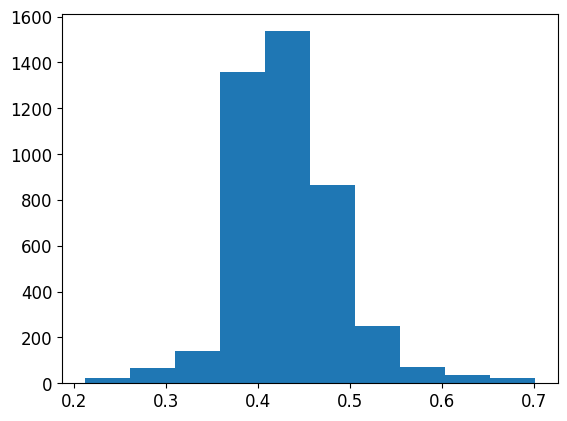

In [267]:
plt.hist(fdm_dist)

In [348]:
radii    = np.arange(0.25, 10, 0.01) # Radii in arcsec

pc       = Jam_Model.distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
radii_pc = radii*pc                        # Radii in pc

dm_radial_density = []

for w in range(a.shape[0]):
    dm_radial_density.append( mge_radial_density(a[w], 
                                b[w], c[w],
                                inc_dist[w][0], radii, Jam_Model.distance) )


In [349]:
fiducial_surf, fiducial_sigma = phase.CombinedModel.mgeDM.fit(10**parsRes["log_rho_s"], 
                                                              parsRes["rs"],
                                                              parsRes["slope"])
fiducial_qobs = np.ones_like(fiducial_surf)

In [350]:
fiducial_density = mge_radial_density(fiducial_surf, 
                                fiducial_sigma, fiducial_qobs,
                                parsRes["inc"], radii, Jam_Model.distance)

In [352]:
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
true_density = dm_hdu[1].data["density"]
true_radii   = dm_hdu[1].data["radius"]
dm_fit       = dm_hdu[1].data["bestfit"]

i = true_radii < radii_pc.max()

true_density = true_density[i]
true_radii   = true_radii[i]
dm_fit = dm_fit[i]

In [353]:
from scipy.stats.mstats import mquantiles


# median and 1sigma band
mean = mquantiles(dm_radial_density, 0.5, axis=0)[0]
lo   = mquantiles(dm_radial_density, 0.025, axis=0)[0]
hi   = mquantiles(dm_radial_density, 0.975, axis=0)[0]

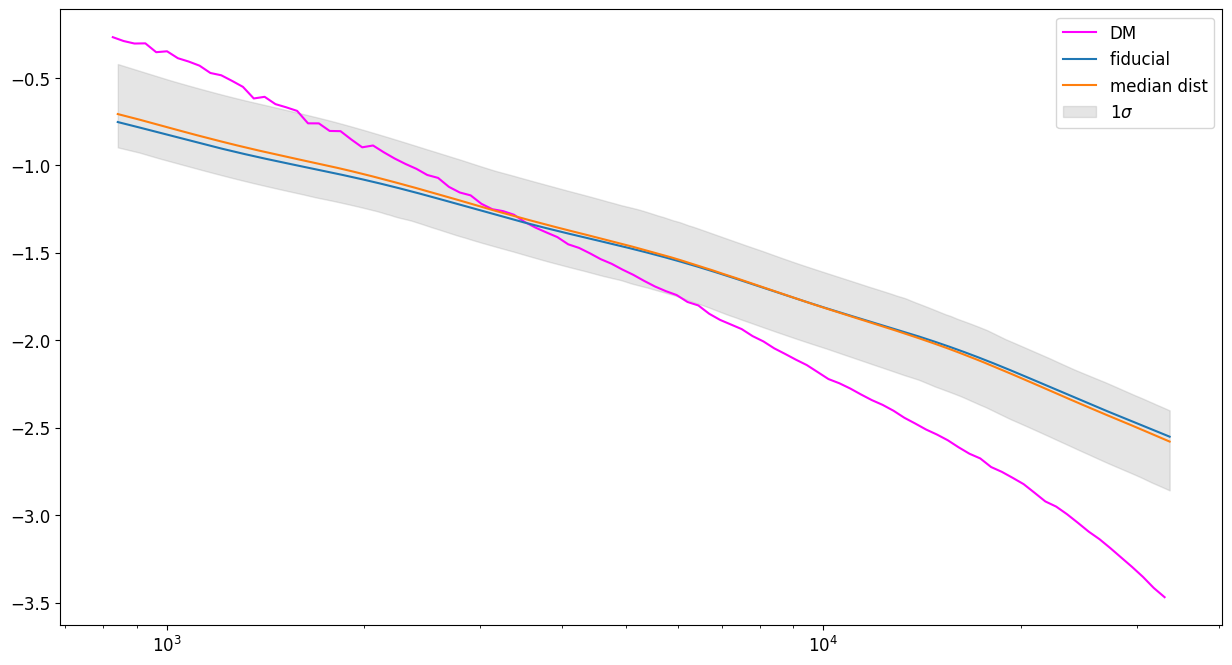

In [354]:
plt.figure(figsize=(15,8))

plt.plot(true_radii, np.log10(true_density), label="DM", color="magenta")
plt.plot(radii_pc, np.log10(fiducial_density), label="fiducial ")
plt.plot(radii_pc, np.log10(mean), label="median dist")
plt.fill_between(radii_pc, np.log10(lo), np.log10(hi), color="gray", alpha=0.2, label="$1\sigma$")
plt.xscale("log")

plt.legend()

In [ ]:
from scipy.stats.mstats import mquantiles


# median and 1sigma band
mean = mquantiles(dm_radial_density, 0.5, axis=0)[0]
lo   = mquantiles(dm_radial_density, 0.025, axis=0)[0]
hi   = mquantiles(dm_radial_density, 0.975, axis=0)[0]

In [289]:
import scipy.stats.mstats

In [290]:
import statistics

In [306]:
dyfunc.quantile(dm_radial_density, 0.5, weights)

MemoryError: Unable to allocate 30.7 GiB for an array with shape (4341, 975, 975) and data type float64

In [299]:
dm_radial_density = np.asarray(dm_radial_density)

In [305]:
dm_radial_density[0].shape

(975,)

In [307]:
weights.shape

(4341,)